https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 0
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.ensemble import IsolationForest
from helpers.feature_engineering import dateStrToDayYear, getMappingOfSimilarCategoricalColumns, \
    compareSimilarCategoricalColumns 
from helpers.my_one_hot_encoder import MyOneHotEncoder
from helpers.py_helpers import is_number
from scipy.stats import skew, kurtosis
from helpers.outliers import MyOutliers
from sklearn.preprocessing import StandardScaler
from helpers.plot_helper import scatter_2d_label, renderPointsWithDecisionBounds
from sklearn.decomposition import PCA # Import the PCA module
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.dummy import DummyClassifier
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from flights_delay.flight_delay_scoring import printFlightDelayScores, getFlightDelayScores
from helpers.my_cross_validation import MyCrossValidation
from sklearn.metrics import log_loss
from helpers.performance_issues import processSeparately
from helpers.plot_helper import scatter_2d_label
from flights_delay.flight_delay_scoring import getScore_onKFold_callback

In [4]:
rng = np.random.RandomState(seed=random_state)
#n_jobs = 3 #we prefer to have it run in only a few cores instead of all of them to avoid making the system unstable
n_jobs = 1  #due to memory restrictions

# Flying to New York City - Naive Bayes Classifier

In [5]:
target_col = 'IS_DELAYED'

In [6]:
path_data = os.path.realpath(os.path.join(os.getcwd(), '../Data',
                                          'binary_train_data_numerical_no_outliers_normalized.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/binary_train_data_numerical_no_outliers_normalized.csv'

In [7]:
df = pd.read_csv(path_data, header=0)
df.shape

(180133, 533)

In [8]:
df.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,...,DEP_TIME_BLK_9,DEP_TIME_BLK_10,DEP_TIME_BLK_11,DEP_TIME_BLK_12,DEP_TIME_BLK_13,DEP_TIME_BLK_14,DEP_TIME_BLK_15,DEP_TIME_BLK_16,DEP_TIME_BLK_17,IS_DELAYED
165999,0.468116,0.157033,1.162862,-0.966237,0.826288,-1.706637,-0.573752,-0.367736,-1.102857,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
118690,-0.441352,-0.731585,-1.453911,1.574641,-0.126675,-1.473074,-0.293951,-0.367736,-0.415552,-0.253819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
170863,-1.350820,-1.323998,-0.885047,-1.474413,-0.466086,-0.556195,-0.675497,-0.742084,0.051700,0.108177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
95968,-1.350820,-1.027791,0.935317,0.050114,1.192461,-1.469214,-0.497442,-0.367736,0.468941,0.470173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
121221,-0.441352,-0.731585,-0.771274,1.066466,-0.928208,1.611501,-0.726370,-0.742084,-1.124291,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [9]:
df.info()  #here we are verifying that everything is numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180133 entries, 0 to 180132
Columns: 533 entries, QUARTER to IS_DELAYED
dtypes: bool(1), float64(532)
memory usage: 731.3 MB


In [10]:
XX = df.drop(labels=[target_col], axis=1)
yy = df[target_col]
XX.shape, yy.shape

((180133, 532), (180133,))

In [11]:
del df  #to save memory

In [12]:
columns_not_one_hot = np.array([col for col in XX.columns if not is_number(col[-1])])
columns_not_one_hot

array(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_NUM',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_GROUP', 'DISTANCE',
       'DISTANCE_GROUP', 'YDAY'], 
      dtype='|S15')

In [13]:
XX[columns_not_one_hot].describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,YDAY
count,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05
mean,-1.484052e-12,3.126480e-13,1.822616e-13,5.892627e-13,-2.010778e-14,-2.247057e-15,8.564950e-15,-2.171187e-13,1.507782e-13,5.062069e-13,-1.497683e-14
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.350820e+00,-1.620204e+00,-1.681456e+00,-1.474413e+00,-1.080291e+00,-2.708448e+00,-1.362280e+00,-1.116432e+00,-1.370063e+00,-1.339808e+00,-1.748677e+00
25%,-4.413519e-01,-7.315854e-01,-8.850472e-01,-9.662371e-01,-7.820001e-01,-8.611779e-01,-6.754973e-01,-7.420838e-01,-7.270543e-01,-6.158155e-01,-8.703420e-01
50%,-4.413519e-01,-1.391733e-01,2.513468e-02,5.011427e-02,-2.526487e-01,6.535273e-02,-4.974424e-01,-3.677355e-01,-1.469179e-01,-2.538192e-01,-1.659459e-03
75%,4.681160e-01,7.494450e-01,8.215438e-01,5.582900e-01,3.341416e-01,8.278103e-01,3.673956e-01,3.809610e-01,4.689412e-01,4.701733e-01,8.380670e-01
max,1.377584e+00,1.638063e+00,1.731726e+00,1.574641e+00,3.774599e+00,1.922275e+00,4.004803e+00,4.124444e+00,2.190775e+00,2.280155e+00,1.774314e+00


### Dummy Classifier

In [14]:
dc = DummyClassifier(random_state=random_state).fit(XX, yy)

In [15]:
dc.score(XX, yy)

0.50231218044444936

In [16]:
dummy_preds = dc.predict(XX)

In [17]:
printFlightDelayScores(y_true=yy, y_pred=dummy_preds)

precision score for delayed flights: 0.485576923077
f1 score for both classes: [ 0.51742959  0.48621698]
f1 score for is_delayed true class: 0.486216975185
f1 score with weighted average: 0.502332107115
f1 score with unweighted average: 0.501823283906


In [18]:
log_loss(y_true = yy, y_pred = dc.predict_proba(XX))

17.18952831409981

### Quadratic Discriminant Classifier

In [19]:
clf = QuadraticDiscriminantAnalysis()

In [20]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [22]:
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))

/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [23]:
scores

precision_score             0.535615
f1_score_nondelayed         0.300545
f1_score_delayed            0.674162
f1_score_weighted_avg       0.481185
f1_score_unweighted_avg     0.487354
log_loss                   13.216625
accuracy_score              0.561280
dtype: float64

## process RBF PCA

In [27]:
def getKernelPCA_X(kernel, inputs, gamma=None, n_jobs=n_jobs, n_components = 2):
    return KernelPCA(n_components=n_components, random_state=random_state, kernel=kernel,
                     gamma=gamma, n_jobs=n_jobs).fit_transform(inputs)

In [33]:
def rbfPCAkernelAndScore(n_components):
    assert n_components >= 2
    def processor(inputs):
        return getKernelPCA_X(kernel='rbf', inputs=inputs, gamma=0.1, n_jobs=n_jobs,
                              n_components=n_components)
    df_lowdim = processSeparately(inputs=XX, targets=yy, processor=processor,
                                  n_components=n_components, n_splits=10)
    XX_lowdim = df_lowdim.drop(labels=[target_col], axis=1)
    yy_lowdim = df_lowdim[target_col]
    cv = MyCrossValidation(n_folds=10, random_state=random_state)
    scores = cv.onEachKFold(XX_lowdim, yy_lowdim, getScore_onKFold_callback(clf))
    
    pd.concat((XX_lowdim, yy_lowdim), axis=1).to_csv(
    os.path.realpath(os.path.join(os.getcwd(), '../Data', 'rbf_pca_kernel_%d_components.csv' % n_components)),
    index=False)
    
    return scores, XX_lowdim, yy_lowdim

### Repeat for different dim reductions

In [30]:
scores, XX_lowdim, yy_lowdim = rbfPCAkernelAndScore(n_components=2)

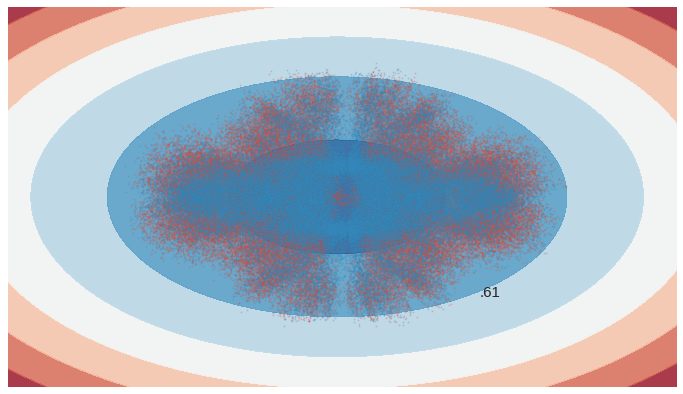

In [36]:
renderPointsWithDecisionBounds(XXX=XX_lowdim.values, yyy= yy_lowdim.values, score=scores['accuracy_score'], clf=clf)
plt.show()

In [38]:
scores

precision_score            0.606216
f1_score_nondelayed        0.636427
f1_score_delayed           0.582280
f1_score_weighted_avg      0.610240
f1_score_unweighted_avg    0.609354
log_loss                   0.675505
accuracy_score             0.611237
dtype: float64

In [39]:
scores, XX_lowdim, yy_lowdim = rbfPCAkernelAndScore(n_components=3)
scores

precision_score            0.587296
f1_score_nondelayed        0.621403
f1_score_delayed           0.561266
f1_score_weighted_avg      0.592314
f1_score_unweighted_avg    0.591334
log_loss                   0.667999
accuracy_score             0.593550
dtype: float64

In [40]:
scores, XX_lowdim, yy_lowdim = rbfPCAkernelAndScore(n_components=4)
scores

precision_score            0.622498
f1_score_nondelayed        0.656752
f1_score_delayed           0.542761
f1_score_weighted_avg      0.601624
f1_score_unweighted_avg    0.599757
log_loss                   0.659975
accuracy_score             0.607879
dtype: float64

In [41]:
scores, XX_lowdim, yy_lowdim = rbfPCAkernelAndScore(n_components=5)
scores

precision_score            0.608578
f1_score_nondelayed        0.637072
f1_score_delayed           0.590958
f1_score_weighted_avg      0.614773
f1_score_unweighted_avg    0.614015
log_loss                   0.653879
accuracy_score             0.615401
dtype: float64

#### Conclusions
???

### T-SNE dim reduction

In [26]:
Xsub, ysub = subsample_keeping_class_proportions(XX=XX, yy=yy, nn=6000, seed=random_state)

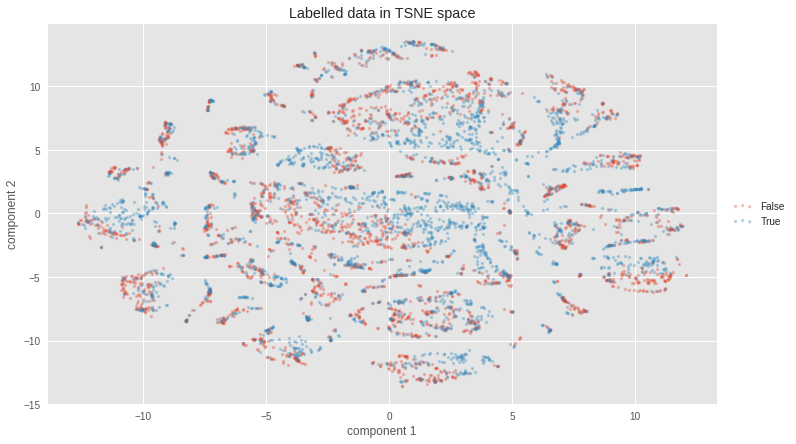

CPU times: user 1min 27s, sys: 6.5 s, total: 1min 33s
Wall time: 1min 29s


In [29]:
%%time

Xtsne = TSNE(n_components=2, perplexity=20, random_state=random_state).fit_transform(Xsub)

plt.figure(figsize=(12,7))
scatter_2d_label(Xtsne, y=ysub, alpha=0.3, s=2, lw=2)
plt.title('Labelled data in TSNE space')
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

Expected time is 60 minutes for perplexity = 30 which is necessary to have some decent seperation

TOO LONG for our current time resources